In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [17]:
df = pd.read_csv('../data/preprocessed/main-data.csv')  

# convert day to numerical
df = pd.get_dummies(df, columns=['day'])
# # One-hot encode categorical features (category_names)
# mlb = MultiLabelBinarizer()
# encoded_categories = mlb.fit_transform(df['category_names'].astype(str).apply(lambda x: x.split(',')))
# encoded_categories_df = pd.DataFrame(encoded_categories, columns=mlb.classes_)
# df = pd.concat([df, encoded_categories_df], axis=1)

df.drop(['category_names'], axis=1, inplace=True)

df['is_vip'] = df['is_vip'].astype(int)

# Define features and target variable
X = df[df.columns.difference(['collection_duration'])]
y = df['collection_duration']

In [8]:
df

,collection_duration,item_count,is_vip,cold_item,frozen_item,scalable_item,month,hour,is_holiday,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2.321213,3,0,2,0,0,5,12,0,False,False,True,False,False,False,False
1,7.183333,39,0,4,0,0,9,13,0,True,False,False,False,False,False,False
2,3.533333,4,0,1,0,0,7,18,0,False,False,False,False,False,False,True
3,4.927150,2,0,0,0,0,11,18,0,False,False,True,False,False,False,False
4,4.450000,9,0,0,0,3,1,17,0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379802,4.466667,3,0,0,0,0,11,18,0,True,False,False,False,False,False,False
1379803,5.050558,6,0,0,0,0,9,10,0,False,False,False,True,False,False,False
1379804,6.616667,3,0,0,0,0,11,17,0,False,False,False,True,False,False,False
1379805,4.877085,4,0,1,0,0,3,17,0,True,False,False,False,False,False,False


In [9]:
# # Check whether the target variable is normally distributed
# columns_with_ones = df.apply(lambda row: row.index[row == 1].tolist(), axis=1)
# print(columns_with_ones)

In [18]:
# Split df into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape , X_test.shape

((1103845, 15), (275962, 15))

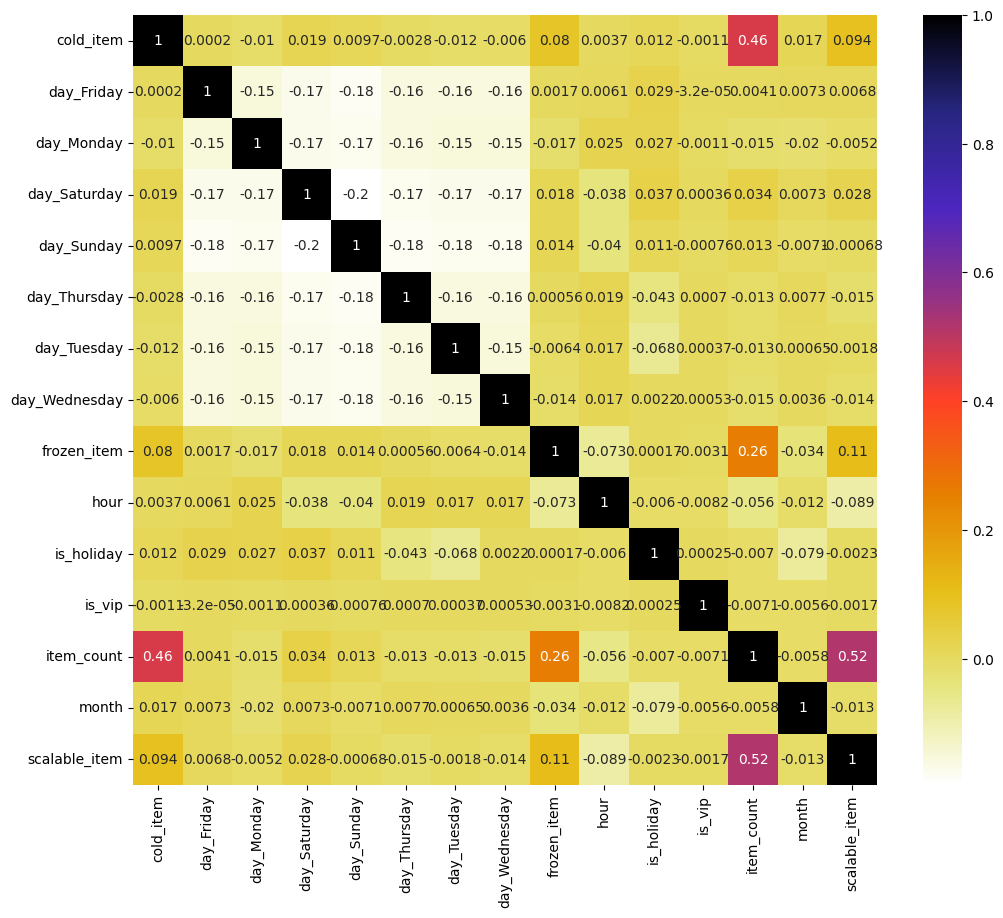

In [11]:
# Correlation matrix map
plt.figure(figsize=(12,10))
cor = X_train.corr() #method='pearson' or 'spearman'
sns.heatmap(cor,annot=True,cmap= plt.cm.CMRmap_r)
plt.show()

In [12]:
def correlation(dataset,threshold):
    col_corr = set() # set all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if(corr_matrix.iloc[i,j])> threshold:
                colname= corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [13]:
# corr_features = correlation(X_train,0.7)
# len(set(corr_features))
# corr_features

In [19]:
# Define hyperparameter grid
parameters = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [7, 10, 15, 20, 25, 30],
    'min_child_weight': [10, 15, 20, 25],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "reg_alpha": [0.5, 0.2, 1],
    "reg_lambda": [2, 3, 5],
    "gamma": [1, 2, 3]
}

# Initialize XGBoost model
xgb_model = XGBRegressor(random_state=42)

In [21]:
# Initialize RandomizedSearchCV
grid_xgb = RandomizedSearchCV(xgb_model, parameters, cv=5, n_iter=10, scoring='neg_mean_absolute_error', verbose=3, n_jobs= -1)

# Fit RandomizedSearchCV
grid_xgb.fit(X_train, y_train)

# Extract best estimator
best_xgb_model = grid_xgb.best_estimator_

# Train final XGBoost model with best hyperparameters
best_xgb_model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate predictions
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)

print("R-squared: %.4f" % rsquared)
print("RMSE: %.4f" % rmse)
print("MAE : %.4f" % mae)

p_accuracy = [(1 - np.abs(pred - actual) / actual) * 100 for pred, actual in zip(y_pred, y_test)]

# Print P_accuracy
print("P_accuracy: Mean: %.2f%%, Min: %.2f%%, Max: %.2f%%" % (np.mean(p_accuracy), np.min(p_accuracy), np.max(p_accuracy)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.3, max_depth=30, min_child_weight=15, n_estimators=200, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-1.565 total time=   3.2s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.3, max_depth=30, min_child_weight=15, n_estimators=200, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-1.565 total time=   3.2s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.3, max_depth=30, min_child_weight=15, n_estimators=200, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-1.564 total time=   3.5s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=3, learning_rate=0.3, max_depth=30, min_child_weight=15, n_estimators=200, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-1.564 total time=   3.5s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=3, l

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END booster=gbtree, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=100, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.564 total time=   8.0s
[CV 4/5] END booster=gbtree, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=100, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-1.563 total time=   8.6s
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.3, max_depth=10, min_child_weight=25, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.551 total time=   4.1s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=1, learning_rate=0.3, max_depth=10, min_child_weight=25, n_estimators=200, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=3;, score=-1.550 total time=   5.5s
[CV 5/5] END booster=gbtree, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:2.04746	validation_1-rmse:2.05064
[4]	validation_0-rmse:2.01105	validation_1-rmse:2.01478
[5]	validation_0-rmse:2.00169	validation_1-rmse:2.00582
[6]	validation_0-rmse:1.98725	validation_1-rmse:1.99201
[7]	validation_0-rmse:1.98422	validation_1-rmse:1.98928
[8]	validation_0-rmse:1.97779	validation_1-rmse:1.98334
[9]	validation_0-rmse:1.97357	validation_1-rmse:1.97948
[10]	validation_0-rmse:1.97128	validation_1-rmse:1.97745
[11]	validation_0-rmse:1.96996	validation_1-rmse:1.97639
[12]	validation_0-rmse:1.96912	validation_1-rmse:1.97585
[13]	validation_0-rmse:1.96804	validation_1-rmse:1.97519
[14]	validation_0-rmse:1.96733	validation_1-rmse:1.97485
[15]	validation_0-rmse:1.96667	validation_1-rmse:1.97460
[16]	validation_0-rmse:1.96610	validation_1-rmse:1.97426
[17]	validation_0-rmse:1.96553	validation_1-rmse:1.97407
[18]	validation_0-rmse:1.96506	validation_1-rmse:1.97394
[19]	validation_0-rmse:1.96458	validation_1-rmse:1.97388
[20]	validation_0-rmse:1.96407	validat

In [22]:
# print best hyperparameters
print(grid_xgb.best_params_)

{'reg_lambda': 3, 'reg_alpha': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 3, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


In [23]:
min_index = np.argmin(p_accuracy)
max_index = np.argmax(p_accuracy)
min_p_accuracy = p_accuracy[min_index]
corresponding_pred = y_pred[min_index]
corresponding_actual = y_test.iloc[min_index]

print("Minimum P_accuracy: %.2f%%" % min_p_accuracy)
print("Corresponding Prediction:", corresponding_pred)
print("Corresponding Actual Value:", corresponding_actual)

Minimum P_accuracy: -98.48%
Corresponding Prediction: 14.675116
Corresponding Actual Value: 4.916666666666667


In [31]:
less_than_zero = [p_acc for p_acc in p_accuracy if p_acc < 0]
more_than_zero = [p_acc for p_acc in p_accuracy if p_acc > 0]

count_less_than_zero = len(less_than_zero)
count_more_than_zero = len(more_than_zero)

print(f"The total {count_more_than_zero} values are greater than 0%.")
print(f"The total {count_less_than_zero} values are less than 0%.")

The total 272438 values are greater than 0%.
The total 3524 values are less than 0%.


In [32]:
# Identify the indices of the 10 lowest P_accuracy values
worst_indices = np.argsort(p_accuracy)[:10]
max_indices = np.argsort(p_accuracy)[-10:]
# Extract the worst 10 features, predicted values, and actual values corresponding to the minimum P_accuracy
worst_features = X_test.iloc[worst_indices]
max_features = X_test.iloc[max_indices]
max_predicted_values = pd.Series(y_pred[max_indices], name='Predicted')
worst_predicted_values = pd.Series(y_pred[worst_indices], name='Predicted')
worst_actual_values = y_test.iloc[worst_indices].reset_index(drop=True)
max_actual_values = y_test.iloc[max_indices].reset_index(drop=True)

max_table = pd.concat([max_features.reset_index(drop=True), max_predicted_values, max_actual_values], axis=1)
# Create a DataFrame to display the features, predicted values, and actual values in a table
worst_table = pd.concat([worst_features.reset_index(drop=True), worst_predicted_values, worst_actual_values], axis=1)

# Print the table of the worst 10 features, predicted values, and actual values corresponding to the minimum P_accuracy
print("Worst 10 Features, Predicted Values, and Actual Values corresponding to Minimum P_accuracy:")
print(worst_table.to_string(index=False))
print('----------------------------------------------------------------------------------------')
print("Max 10 Features, Predicted Values, and Actual Values corresponding to Maximum P_accuracy:")
print(max_table.to_string(index=False))

Worst 10 Features, Predicted Values, and Actual Values corresponding to Minimum P_accuracy:
 cold_item  day_Friday  day_Monday  day_Saturday  day_Sunday  day_Thursday  day_Tuesday  day_Wednesday  frozen_item  hour  is_holiday  is_vip  item_count  month  scalable_item  Predicted  collection_duration
         5       False       False         False        True         False        False          False            0     9           0       0          27     12             10  14.675116             4.916667
         6       False       False         False        True         False        False          False            1     9           0       0          28     11              3  17.275517             5.816667
         2       False       False          True       False         False        False          False            0    19           0       0          29     11              0  15.155702             5.166667
         5       False       False          True       False         False  

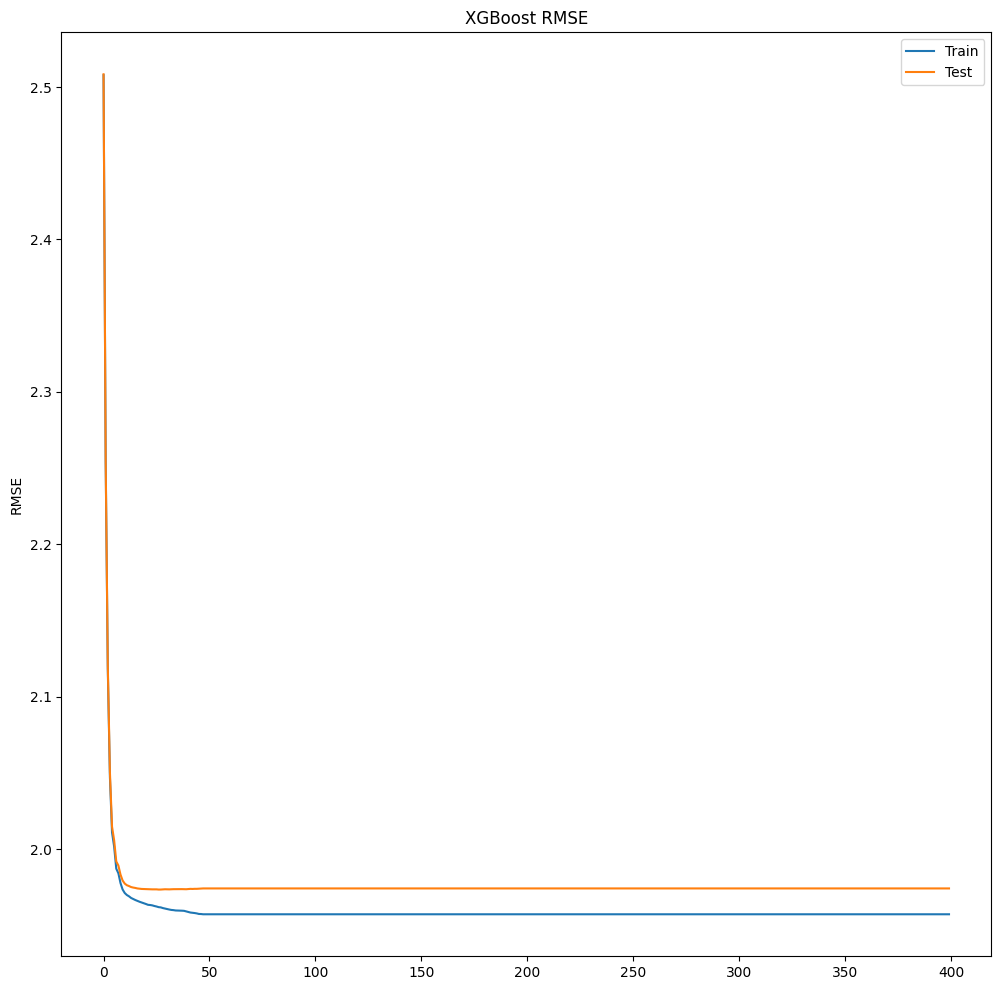

In [33]:
# Retrieve performance metrics
results = best_xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

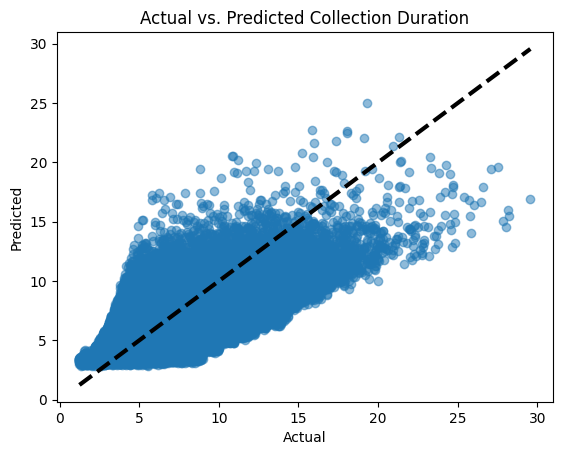

In [34]:
# Plot predicted vs. actual values
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3, label='Ideal Prediction')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Collection Duration")
plt.show()

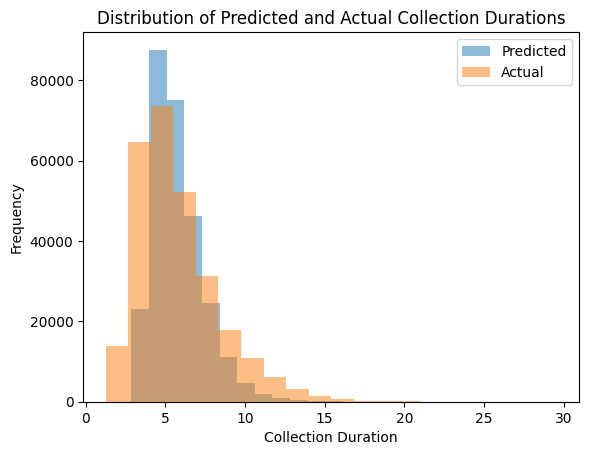

In [35]:
# Plot the distribution of predicted values
plt.hist(y_pred, bins=20, alpha=0.5, label='Predicted')
plt.hist(y_test, bins=20, alpha=0.5, label='Actual')
plt.xlabel('Collection Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted and Actual Collection Durations')
plt.legend()
plt.show()

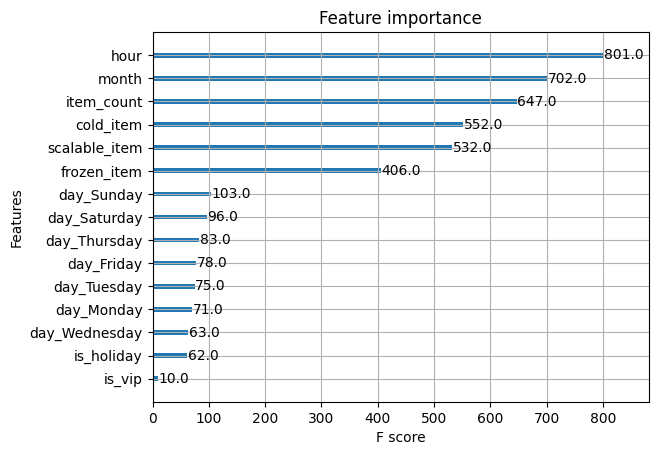

In [36]:
# Plot the first 25 most important features
plot_importance(best_xgb_model, max_num_features=25)
plt.show()